In [135]:
%matplotlib inline
import numpy as np
import pandas as pa
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob, os
import matplotlib.style as style 
#style.available
plt.style.use('seaborn') 
#style.use('seaborn-poster') #sets the size of the charts
import pprint

In [136]:
#Clean up result directory first
results_path = 'timing_results/*'
r = glob.glob(results_path)
for i in r:
    os.remove(i)

#Then clean the plan directory
plans_path = 'query_plans/*'
r = glob.glob(plans_path)
for i in r:
    os.remove(i)
    
#Then clean the timing_results directory
timing_histogram_path = 'hist_timing_results/*'
r = glob.glob(plans_path)
for i in r:
    os.remove(i)
    
#Setup variables
result_list = []
histogram_timing_results_list = []
query_plan_list = []
i = -1

# Format the .result files from our mtr run so that we can import them using pandas csv importer

In [137]:
with open("../code/mysql-server/mysql-test/suite/histogram_plugin/r/execute_timing.result") as openfileobject:
    for line in openfileobject:
        if not "#" in line[:5]:
            if "Query" in line:
                i+=1
                result_list.append([line]) 
                query_plan_list.append([])
            if "Analyse statement" in line[:17]:
                histogram_timing_results_list.append([line])
            if "select" in line[:8]:
                result_list[i].append(line)
            if "EXPLAIN" in line[:7] or "->" in line or "id" in line[:4] or "1" in line[:2]:
                query_plan_list[i].append(line)
            if "explain" in line[:7]:
                query_plan_list[i].append("\n")
                query_plan_list[i].append(line)
            if "analyze table measurement" in line.lower():
                histogram_timing_results_list[i].append(line)
    i = -1   #Cleanup


In [138]:
#Export the timing results for queries
array_result = np.array(result_list)
result_list=[]      #Cleanup so that we can run the cells again and again without having to restart our kernel. 
counter = 0
for result in array_result:
    string="timing_results/{}.csv".format(counter)
    f = open(string,"w+")
    for line in result:
        f.write(line)
    f.close()
    counter+=1

    
#Export the timing results for histograms
array_hist_result = np.array(histogram_timing_results_list)
histogram_timing_results_list = []
counter = 0
for hist_result in array_hist_result:
    string="hist_timing_results/{}.csv".format(counter)
    f = open(string,"w+")
    for line in hist_result:
        f.write(line)
    f.close()
    counter+=1

# Now let's import the csv files into a dataframe. 

In [139]:
result_files = sorted(glob.glob(results_path),key=lambda x: int(x.split('.')[0][15:]))
frames = []
helper = []
counter = 0
for file in result_files:
    temp_df = pa.read_csv(str(file),'\t')
    helper.append([temp_df.iloc[0]['Test type'],counter])
    frames.append(temp_df)
    counter+=1

result_df = pa.concat(frames,sort=False)



hist_result_files = sorted(glob.glob(timing_histogram_path),key=lambda x: int(x.split('.')[0][20:]))
frames = []
counter = 0
for file in hist_result_files:
    temp_df = pa.read_csv(str(file),'\t')
 #   helper.append([temp_df.iloc[0]['Test type'],counter])
    frames.append(temp_df)
    counter+=1

hist_result_df = pa.concat(frames,sort=False)


In [140]:

#Export the query_plans
array_query_plan = np.array(query_plan_list)
query_plan_list=[]
counter = 0
for plan_set in array_query_plan:
    string="query_plans/plan_{}_{}.txt".format(counter,helper[counter][0].strip())
    f = open(string,"w+")
    for plan in plan_set:
        f.write(plan)
    f.close()
    counter+=1

In [146]:
hist_result_df.head(500)

,Analyse statement,Duration,Test type,Number of Inserts
0,analyze table measurement update histogram on msm_value,0.102727,Perfect histogram,100000
0,analyze table measurement update histogram on msm_value,0.092523,Perfect histogram,200000
0,analyze table measurement update histogram on msm_value,0.100429,Perfect histogram,300000
0,analyze table measurement update histogram on msm_value,0.084871,Perfect histogram,400000
0,analyze table measurement update histogram on msm_value,0.092783,Perfect histogram,500000
0,analyze table measurement update histogram on msm_value,0.108817,Perfect histogram,600000
0,analyze table measurement update histogram on msm_value,0.089091,Perfect histogram,700000
0,analyze table measurement update histogram on msm_value,0.094775,Perfect histogram,800000
0,analyze table measurement update histogram on msm_value,0.093804,Perfect histogram,900000
0,analyze table measurement update histogram on msm_value,0.083660,Perfect histogram,1000000


# Format the queries to be q1 q2 etc. add a result_ratio column and a formatted query column

In [141]:
i=1
replace_dictionary = {}
unique_queries = result_df.Query.unique().tolist()
for query in unique_queries:
    name = 'q{}'.format(i)
    replace_dictionary[query]=name
    i+=1

result_df['Short_Query']=result_df['Query'].replace(replace_dictionary)

partition_size = min(result_df["Number of Inserts"].unique().tolist())
result_df['Result_ratio']=result_df['Returned rows']/partition_size

queries = result_df['Query'].tolist()
short_query_format=[]
for query in queries:
    no_of_joins = query.count('join')
    where_predicate_value = query.split("test.measurement.msm_value",1)[1]
    short_query_format.append('Query with '+str(no_of_joins)+' joins and WHERE MSM_VALUE' +where_predicate_value)
result_df['Short_query_format']=short_query_format




In [142]:
unformatted_plan_files = glob.glob(plans_path)
for file in unformatted_plan_files:
    output_file_name=file+".tmp"
    with open(file, 'r') as f, open(output_file_name, 'w+') as fo:
        for line in f:
            formatted_line = line.replace('explain format = tree ', '').replace(";","") 
           # print(formatted_line) 
            for query,key in replace_dictionary.items():
                if query==formatted_line:
                    fo.write(key)
                    break
            fo.write(line)
    os.remove(file)

## Prelim-results, don't run unless running prelim tests

In [132]:
#ax=sns.lineplot(x="Number of Inserts", y="Duration",
#            hue="Test type", markers=True,
#            data=result_df[result_df.Short_Query.isin(['q2'])])
#q2_prelim_line_plot = plt.gcf()
#q2_prelim_line_plot.savefig("/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/plots/prelim/q2_prelim_line_plot.png",dpi=360)
#plt.show()

## Standard results

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

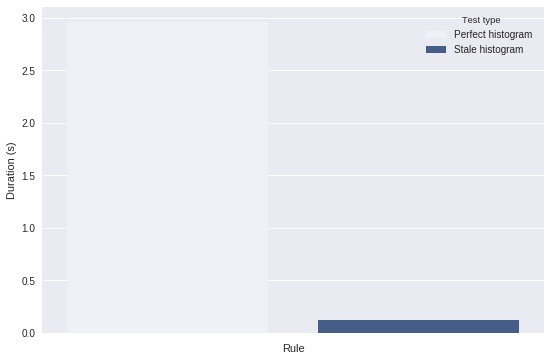

In [143]:
for query in result_df.Short_Query.unique().tolist():
    fig = plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(nrows=4, 
                           ncols=1, 
                           figure=fig, 
                           height_ratios=[1, 1, 1, 1],
                           wspace=0.3,
                           hspace=0.3)

    ax1 = fig.add_subplot(gs[1:3,0])
    sns.lineplot(x="Number of Inserts", y="Duration",
                 hue="Test type", style="Test type", markers=True,
                 data=result_df[result_df.Short_Query.isin([query])],ax=ax1)
    xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()/1000]
    ax1.set_xticklabels(xlabels)
    ax1.set_xlabel("Number of inserts")
    ax1.set_ylabel("Duration (s)")
   # ax1.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))

    ax2 = fig.add_subplot(gs[0, 0])

    all_hist = result_df[result_df["Test type"].str.contains('Perfect histogram')]
    index_position = all_hist[all_hist.Short_Query.isin([query])].index[0]
    final = all_hist[all_hist.Short_Query.isin([query])].loc[index_position]
    sns.barplot(x="Number of Inserts", y="Result_ratio",data=final ,ax=ax2, color=sns.xkcd_rgb["denim blue"])
    

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    #ax2.xaxis.set_major_locator(ax1.xaxis.get_major_locator())
    #ax2.set_xticklabels(ax1.get_xticklabels())
    ax2.set_xticklabels("")
    ax2.margins(x=ax1.margins()[0]-0.01)
    ax2.set_xlabel("")
    ax2.set_ylabel("Result size ratio")
  #  ax2.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))
    
    fig.suptitle(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]),y=0.9)
    
    line_plot = plt.gcf()
    
    path = "/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/all_q_plots/"
    name = query+".png"
    line_plot.savefig(path+name,dpi=360,bbox_inches='tight')
    plt.clf()
    
fig = plt.figure(figsize=(9,6))
ax3=sns.barplot(x="Test type", y="Duration",hue="Test type", data=hist_result_df, estimator=sum,ci=None,dodge = False, color=sns.xkcd_rgb["denim blue"])
ax3.set_xticklabels("")
ax3.set_xlabel("Rule")
ax3.set_ylabel("Duration (s)")
hist_timing_plt = plt.gcf()
hist_timing_plt.savefig("/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/plots/histogram_timing.png",dpi=360,bbox_inches='tight')

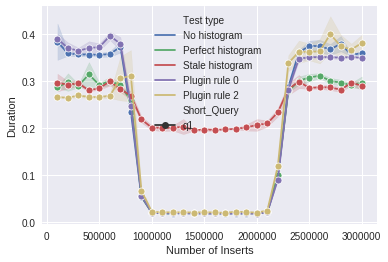

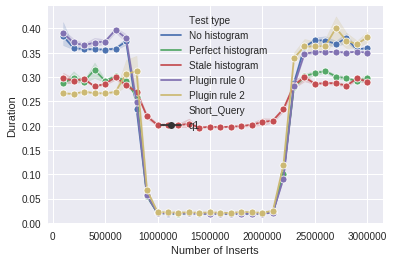

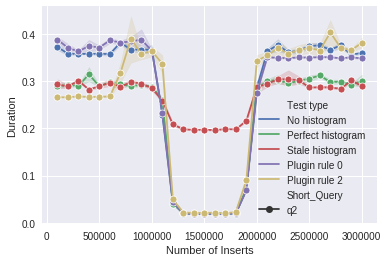

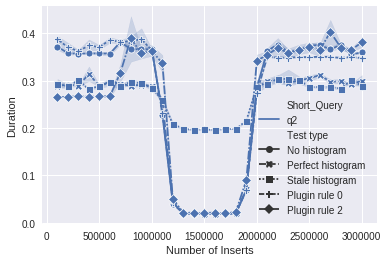

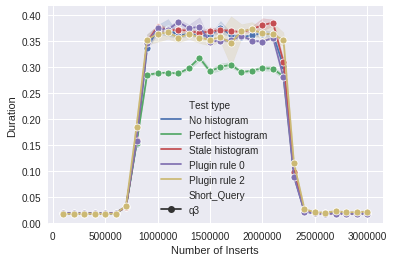

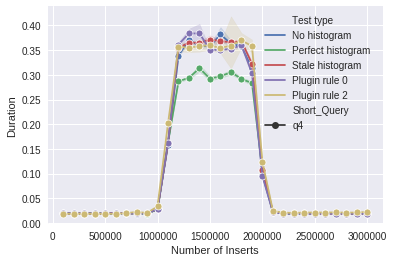

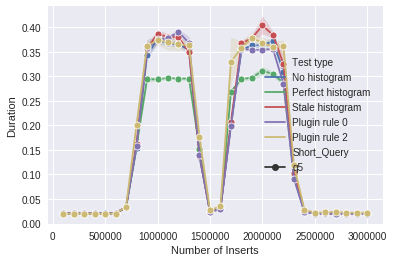

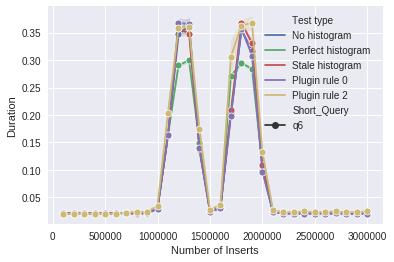

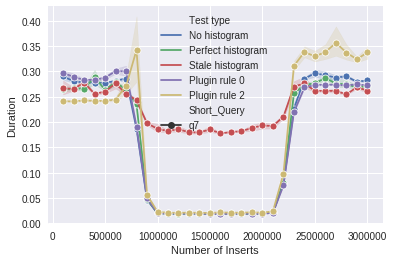

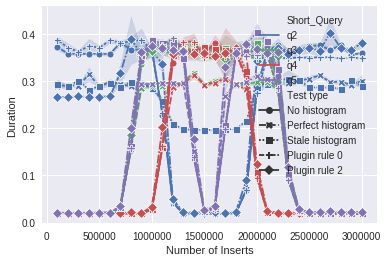

In [12]:
#plt.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off2776
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) 
#ax = sns.catplot(x='Short_Query', y='Duration', hue="Test type",
#                 data=result_df[result_df.Short_Query.isin(['q1','q4'])], palette="Set3",kind="violin",col="Number of Inserts",legend_out = True,col_wrap=5)
#ax.set_yscale('log')
#ax._legend.set_title("Rule")
#axes  =ax.axes.flatten()
#for x in axes:
#    x.set_xlabel("Query")
#plt.tight_layout()
#plt.subplots_adjust(hspace=0.3)
#plt.show()

#ax = sns.catplot(x='Short_Query', y='Duration', hue="Test type",
#                 data=result_df, palette="Set3",kind="violin",col="Number of Inserts")
#ax.set_yscale('log')
#plt.show()

#ax = sns.catplot(x='Short_Query', y='Duration', hue="Test type",
#                 data=result_df[result_df.Short_Query.isin(['q2'])], palette="Set3",kind="violin",col="Number of Inserts",legend_out = True,col_wrap=5)
#ax._legend.set_title("Rule")
#axes  =ax.axes.flatten()
#for x in axes:
#    x.set_xlabel("Query")
#plt.subplots_adjust(hspace=0.3)
#q2_violin_plot = plt.gcf()
#q2_violin_plot.savefig("/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/plots/q2_violin_plot.png",dpi=360)
#ax.set_yscale('log')
#plt.show()

#ax = sns.catplot(x='Short_Query', y='Duration', hue="Test type",
#                 data=result_df[result_df.Short_Query.isin(['q2'])], palette="Set3",kind="box",col="Number of Inserts",legend_out = True,col_wrap=5)
#ax._legend.set_title("Rule")
#axes  =ax.axes.flatten()
#for x in axes:
#    x.set_xlabel("Query")
#plt.subplots_adjust(hspace=0.3)
#q2_box_plot = plt.gcf()
#q2_box_plot.savefig("/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/plots/q2_box_plot.png",dpi=360)
#ax.set_yscale('log')
#plt.show()

#ax = sns.boxplot(x='Short_Query', y='Duration', hue="Test type",
#                 data=result_df[result_df.Short_Query.isin(['q2','q3'])], palette="Set3")
#ax.set_yscale('log')
#plt.show()

#ax = sns.boxplot(x='Short_Query', y='Duration', hue="Test type",
#                 data=result_df[result_df.Short_Query.isin(['q5','q6'])], palette="Set3")
#ax.set_yscale('log')
#plt.show()

#ax = sns.boxplot(x='Short_Query', y='Duration', hue="Test type",
#                 data=result_df[result_df.Short_Query.isin(['q7','q9'])], palette="Set3")
#ax.set_yscale('log')
#plt.show()

#ax = sns.boxplot(x='Query', y='Duration', hue="Test type",
      #           data=result_df[result_df.Query.isin(['q10'])], palette="Set3")
#ax.set_yscale('log')
#plt.show()

#ax = sns.boxplot(x='Query', y='Duration', hue="Test type",
       #          data=result_df[result_df.Query.isin(['q8'])], palette="Set3")
#ax.set_yscale('log')
#plt.show()

#ax = sns.boxplot(x='Query', y='Duration', hue="Test type",
        #         data=result_df[result_df.Query.isin(['q21'])], palette="Set3")
#ax.set_yscale('log')
#plt.show()

#ax = sns.boxplot(x='Query', y='Duration', hue="Test type",
         #        data=result_df[result_df.Query.isin(['q25'])], palette="Set3")
#ax.set_yscale('log')
#plt.show()

#ax2 = sns.boxplot(x='Returned rows', y='Duration', hue="Test type",
#                 data=result_tot_df[result_tot_df.Query.isin(['q25'])], palette="Set3")
#ax2.set_yscale('log')
#plt.show()


#ax3 = sns.boxplot(x='Short_Query', y='Duration', hue="Test type",
#                 data=result_df, palette="Set3")
#plt.show()

#ax3 = sns.boxplot(x='Number of Inserts', y='Duration', hue="Test type",
#                 data=result_df, palette="Set3")
#plt.show()

line=sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q1'])],ci='sd')
#line.set_yscale('log')
plt.show()

line=sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q1'])])
#line.set_yscale('log')
plt.show()


line=sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q2'])])

plt.show()

line=sns.lineplot(x="Number of Inserts", y="Duration",
             style="Test type", hue="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q2'])])

plt.show()

line=sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q3'])])
plt.show()


line=sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q4'])])
plt.show()

line=sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q5'])])
plt.show()

line=sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q6'])])
plt.show()

line=sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q7'])])
plt.show()


line=sns.lineplot(x="Number of Inserts", y="Duration",
             style="Test type", hue="Short_Query", markers=True,
             data=result_df[result_df.Short_Query.isin(['q2','q3','q4','q5'])])
#line.set_yscale('log')
plt.show()
#line=sns.lineplot(x="Returned rows", y="Duration",
#             hue="Test type", style="Query", markers=True,
#             data=result_tot_df[result_tot_df.Query.isin(['q25'])])
#line.set_yscale('log')
#plt.show()
#ax.set_xlabel('Query',fontsize=14)

#ax = sns.boxplot(x='Short_Query', y='Duration', hue="Test type",
#                 data=result_df[result_df.Short_Query.isin(['q16','q17'])], palette="Set3")
#ax.set_yscale('log')
#plt.show()

In [134]:
query = 'q2'
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(nrows=4, 
                       ncols=1, 
                       figure=fig, 
                       height_ratios=[1, 1, 1, 1],
                       wspace=0.3,
                       hspace=0.3)

ax1 = fig.add_subplot(gs[1:3,0])
sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Test type", markers=True,
             data=result_df[result_df.Short_Query.isin([query])& result_df['Test type'].isin(['No histogram ','Perfect histogram ','Plugin rule 2'])],ax=ax1)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()/1000]
ax1.set_xticklabels(xlabels)
ax1.set_xlabel("Number of inserts")
ax1.set_ylabel("Duration (s)")
# ax1.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))

ax2 = fig.add_subplot(gs[0, 0])

all_hist = result_df[result_df["Test type"].str.contains('Perfect histogram')]
index_position = all_hist[all_hist.Short_Query.isin([query])].index[0]
final = all_hist[all_hist.Short_Query.isin([query])].loc[index_position]
sns.barplot(x="Number of Inserts", y="Result_ratio",data=final ,ax=ax2, color=sns.xkcd_rgb["denim blue"])


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.xaxis.set_major_locator(ax1.xaxis.get_major_locator())
#ax2.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels("")
ax2.margins(x=ax1.margins()[0]-0.01)
ax2.set_xlabel("")
ax2.set_ylabel("Result size ratio")
#  ax2.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))

fig.suptitle(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]),y=0.9)

line_plot = plt.gcf()

path = "/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/One_off_plots/"
name = query+".png"
line_plot.savefig(path+name,dpi=360,bbox_inches='tight')
plt.clf()

<Figure size 648x648 with 0 Axes>

In [122]:
result_df[result_df.Short_Query.isin([query]) & result_df['Test type'].isin(['No histogram ','Perfect histogram ','Plugin rule 2'])]



,Query,Duration,Returned rows,Test type,Number of Inserts,Short_Query,Result_ratio,Short_query_format
9,select * from test.measurement join test.server on test.measurement.msm_serv_id = test.server.serv_id join test.rack on test.rack.rack_id = test.server.serv_rack_id join test.center on test.center.cent_id = test.rack.rack_cent_id join test.city on test.city.city_id = test.center.cent_city_id where test.measurement.msm_value <90,0.368812,100000,No histogram,100000,q2,1.0,Quey with 4 joins and WHERE msm_value <90
10,select * from test.measurement join test.server on test.measurement.msm_serv_id = test.server.serv_id join test.rack on test.rack.rack_id = test.server.serv_rack_id join test.center on test.center.cent_id = test.rack.rack_cent_id join test.city on test.city.city_id = test.center.cent_city_id where test.measurement.msm_value <90,0.360701,100000,No histogram,100000,q2,1.0,Quey with 4 joins and WHERE msm_value <90
11,select * from test.measurement join test.server on test.measurement.msm_serv_id = test.server.serv_id join test.rack on test.rack.rack_id = test.server.serv_rack_id join test.center on test.center.cent_id = test.rack.rack_cent_id join test.city on test.city.city_id = test.center.cent_city_id where test.measurement.msm_value <90,0.373617,100000,No histogram,100000,q2,1.0,Quey with 4 joins and WHERE msm_value <90
12,select * from test.measurement join test.server on test.measurement.msm_serv_id = test.server.serv_id join test.rack on test.rack.rack_id = test.server.serv_rack_id join test.center on test.center.cent_id = test.rack.rack_cent_id join test.city on test.city.city_id = test.center.cent_city_id where test.measurement.msm_value <90,0.390078,100000,No histogram,100000,q2,1.0,Quey with 4 joins and WHERE msm_value <90
13,select * from test.measurement join test.server on test.measurement.msm_serv_id = test.server.serv_id join test.rack on test.rack.rack_id = test.server.serv_rack_id join test.center on test.center.cent_id = test.rack.rack_cent_id join test.city on test.city.city_id = test.center.cent_city_id where test.measurement.msm_value <90,0.370594,100000,No histogram,100000,q2,1.0,Quey with 4 joins and WHERE msm_value <90
...,...,...,...,...,...,...,...,...
13,select * from test.measurement join test.server on test.measurement.msm_serv_id = test.server.serv_id join test.rack on test.rack.rack_id = test.server.serv_rack_id join test.center on test.center.cent_id = test.rack.rack_cent_id join test.city on test.city.city_id = test.center.cent_city_id where test.measurement.msm_value <90,0.381028,100000,Plugin rule 2,3000000,q2,1.0,Quey with 4 joins and WHERE msm_value <90
14,select * from test.measurement join test.server on test.measurement.msm_serv_id = test.server.serv_id join test.rack on test.rack.rack_id = test.server.serv_rack_id join test.center on test.center.cent_id = test.rack.rack_cent_id join test.city on test.city.city_id = test.center.cent_city_id where test.measurement.msm_value <90,0.376095,100000,Plugin rule 2,3000000,q2,1.0,Quey with 4 joins and WHERE msm_value <90
15,select * from test.measurement join test.server on test.measurement.msm_serv_id = test.server.serv_id join test.rack on test.rack.rack_id = test.server.serv_rack_id join test.center on test.center.cent_id = test.rack.rack_cent_id join test.city on test.city.city_id = test.center.cent_city_id where test.measurement.msm_value <90,0.411755,100000,Plugin rule 2,3000000,q2,1.0,Quey with 4 joins and WHERE msm_value <90
16,select * from test.measurement join test.server on test.measurement.msm_serv_id = test.server.serv_id join test.rack on test.rack.rack_id = test.server.serv_rack_id join test.center on test.center.cent_id = test.rack.rack_cent_id join test.city on test.city.city_id = test.center.cent_city_id where test.measurement.msm_value <90,0.350000,100000,Plugin rule 2,3000000,q2,1.0,Quey with 4 joins and WHERE msm_value <90


In [120]:
result_df['Test type'].unique().tolist()

['No histogram ',
 'Perfect histogram ',
 'Stale histogram ',
 'Plugin rule 0',
 'Plugin rule 2']

In [ ]:
pprint.pprint(replace_dictionary.items())

In [ ]:
d = {'Fixed data without Histograms': result_0_df, 'Fixed data with Histograms': result_1_df}
temp=pa.concat(d,axis=1)
temp=temp.transpose().drop(index='Average',level=1)
temp = temp.drop(index='Returned rows',level=1)
#temp = temp.drop(index='Query',level=1)
temp2=pa.concat([result_0_df,result_1_df],join='inner',axis=1)
temp2=temp2.drop(columns='Average')

In [ ]:
temp

In [ ]:
temp.unstack(level=0)

In [ ]:
temp.unstack(level=0).transpose()

In [ ]:
plt.errorbar(temp.unstack(level=0)[8].transpose()['Adjusted average'],temp.unstack(level=0)[8].transpose()['Standard Deviation'])

In [ ]:
plt.errorbar([1,2,3,4,5,6,7],[1,2,3,4,5,6,7],yerr=2)

In [ ]:
midx = pa.MultiIndex(levels=[['zero', 'one'], ['x', 'y']],
   ....:                      codes=[[1, 1, 0, 0], [1, 0, 1, 0]])
df = pa.DataFrame(np.random.randn(4, 2), index=midx)

In [ ]:
df.transpose()

In [ ]:
df.transpose().plot.box()

In [ ]:
midx = pa.MultiIndex(levels=[['without_histogram', 'with_histogram'], ['q1', 'q2', 'q3']],
   ....:                      codes=[[1, 1, 0, 0], [1, 0, 1, 0]])
df = pa.DataFrame(np.random.randn(4, 4), index=midx)

In [ ]:
df

In [ ]:

iterables = [['without_histogram','with_histogram'], ['q1', 'q2','q3'],['r1','r2','r3','r4','r5','r6','r7','r8']]

mindex=pa.MultiIndex.from_product(iterables, names=['Test type', 'Query','Run#'])
df = pa.DataFrame(np.random.randn(48), index=mindex)
df

In [ ]:
df.unstack(level=1).plot.box()

In [ ]:
df.unstack(level=1)

In [ ]:
series=result_0_df.drop(columns=['Average','Standard Deviation','Returned rows','Query'])
series.set_index('Adjusted average')
series.dtypes

result=pa.DataFrame(result_tot_df['Adjusted average'].values, index=mindex)

In [ ]:
result

In [ ]:
result.unstack(level=[0,1]).boxplot()

In [ ]:
result.unstack(level=[1])

In [ ]:
result

In [ ]:
df = pa.DataFrame(np.random.randn(10, 2),
...                   columns=['Col1', 'Col2'])
>>> df['X'] = pa.Series(['A', 'A', 'A', 'A', 'A',
...                      'B', 'B', 'B', 'B', 'B'])
>>> boxplot = df.boxplot(by='X')

In [ ]:
df

In [ ]:
np.random.seed(45)
a = pa.DataFrame(index=range(10), 
                 columns=pa.MultiIndex.from_product(
                         iterables=[['2000', '2010'], ['a', 'b']], 
                         names=['Year', 'Text']), 
                 data=np.random.randn(10,4))

b = a.stack(level=0).reset_index(level=0, drop=True).reset_index()

In [ ]:
b

In [ ]:
b = a.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='data')
b.head(15)

In [ ]:
a.head(15)

In [ ]:
ax = sns.boxplot(x='Text', y='data', hue="Year",
                 data=b, palette="Set3")

In [ ]:
result_tot_2_df